In [76]:
import pandas as pd
import os
from typing import List
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTE


In [3]:
go_file = "/Users/kajolpatel/Desktop/Individual_Project/poc/go-basic.obo"

### Parse the Dataset

In [4]:
def parse_obo_file(file_path):
    
    data = []
    current_term = {}
    in_term_block = False
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '[Term]':  #starting a new term block
                if current_term:
                    data.append(current_term)
                current_term = {}
                in_term_block = True
            elif line == '':
                in_term_block = False  #end of a term block
            elif in_term_block:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    if key in current_term:  #handling multiple lines of the same key
                        if isinstance(current_term[key], list):
                            current_term[key].append(value)
                        else:
                            current_term[key] = [current_term[key], value]
                    else:
                        current_term[key] = value

    
    if current_term: #add the last term if file does not end with a newline
        data.append(current_term)

    return pd.DataFrame(data)

df = parse_obo_file(go_file)


In [5]:
#ypdating 'def' column to 'definition'
df = df.rename(columns={'def': 'definition'}) 

In [6]:
df.head(4)

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN


In [7]:
df['id'].nunique()

47856

In [8]:
df.namespace.nunique()

3

In [9]:
df.namespace.value_counts()


namespace
biological_process    30723
molecular_function    12614
cellular_component     4519
Name: count, dtype: int64

In [10]:
df[df.is_obsolete == 'true']

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
2,GO:0000003,obsolete reproduction,biological_process,"""OBSOLETE. The production of new individuals t...","""reproductive physiological process"" EXACT []",NaN,"[GO:0019952, GO:0050876]",The reason for obsoletion is that this term is...,true,GO:0022414,NaN,NaN,NaN,NaN
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,"""OBSOLETE. Assists in the correct assembly of ...","""ribosomal chaperone activity"" EXACT []",NaN,NaN,This term was made obsolete because it refers ...,true,NaN,"[GO:0042254, GO:0044183, GO:0051082]",NaN,NaN,NaN
6,GO:0000008,obsolete thioredoxin,molecular_function,"""OBSOLETE. A small disulfide-containing redox ...","""thioredoxin"" EXACT []",NaN,GO:0000013,This term was made obsolete because it represe...,true,NaN,"[GO:0003756, GO:0015036]",NaN,NaN,NaN
17,GO:0000020,obsolete negative regulation of recombination ...,biological_process,"""OBSOLETE. Any process that stops, prevents, o...","""negative regulation of recombination within r...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,GO:0045950,NaN,NaN,NaN
33,GO:0000039,obsolete plasma membrane long-chain fatty acid...,molecular_function,"""OBSOLETE. (Was not defined before being made ...","""plasma membrane long-chain fatty acid transpo...",NaN,NaN,This term was made obsolete because it describ...,true,NaN,"[GO:0005324, GO:0005886]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47792,GO:2001254,obsolete negative regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that stops, prevents or...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0006338,NaN,NaN,NaN
47793,GO:2001255,obsolete positive regulation of histone H3-K36...,biological_process,"""OBSOLETE. Any process that activates or incre...",NaN,NaN,NaN,This term was obsoleted because it represents ...,true,NaN,GO:0140673,NaN,NaN,NaN
47811,GO:2001273,obsolete regulation of glucose import in respo...,biological_process,"""OBSOLETE. Any process that modulates the freq...","""regulation of cellular glucose import in resp...",NaN,NaN,This term was obsoleted because it represents ...,true,NaN,NaN,NaN,NaN,NaN
47812,GO:2001274,obsolete negative regulation of glucose import...,biological_process,"""OBSOLETE. Any process that stops, prevents or...","""negative regulation of cellular glucose impor...",NaN,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN


In [11]:
df[df.is_obsolete.isna() == True]

,id,name,namespace,definition,synonym,is_a,alt_id,comment,is_obsolete,replaced_by,consider,xref,subset,relationship
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","""mitochondrial inheritance"" EXACT []","[GO:0048308 ! organelle inheritance, GO:004831...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,GO:0007005 ! mitochondrion organization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,GO:0005385 ! zinc ion transmembrane transporte...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...","""1,6-alpha-mannosyltransferase activity"" EXACT []",GO:0000030 ! mannosyltransferase activity,NaN,NaN,NaN,NaN,NaN,"Reactome:R-HSA-449718 ""Addition of a third man...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47851,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways involving...","""UDP-4-deoxy-4-formamido-beta-L-arabinopyranos...","[GO:0006040 ! amino sugar metabolic process, G...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47852,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009227 ! nucleotide-sugar catabolic proce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47853,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,"""The chemical reactions and pathways resulting...","[""UDP-4-deoxy-4-formamido-beta-L-arabinopyrano...",[GO:0009226 ! nucleotide-sugar biosynthetic pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47854,GO:2001316,kojic acid metabolic process,biological_process,"""The chemical reactions and pathways involving...","[""5-hydroxy-2-(hydroxymethyl)-4H-pyran-4-one m...",[GO:0034308 ! primary alcohol metabolic proces...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

### 1. Remove obsolete terms

In [12]:
df.is_obsolete.value_counts()

is_obsolete
true    5653
Name: count, dtype: int64

In [13]:
df = df[df.is_obsolete.isna() == True]

In [14]:
df.namespace.value_counts()

namespace
biological_process    27014
molecular_function    11132
cellular_component     4057
Name: count, dtype: int64

### 2. Remove unnecessary columns

In [15]:
df = df[['id','namespace','definition']]

### 3. Convert the defintions into feature vectors 
The stop words will be removed in process.

Note that when transforming the definitions to feature vectors, there are 38093 columns created which may create issues like overfitting, curse of dimensionality, etc. 

To handle this we will exclude some words that do not appear in some % of definitions. 

We will test for words that do not appear in 1% of definitions and 5% of definitions.
For this experiment, we create 2 separate datasets.

(Where one dataset excludes the words that do not appear in 1% of the defintions and the other dataset that excludes words that do not appear in 5 % of the definitions)

#### a. Dataset that excludes words that do not appear in 1% of definitions

This gives 202 columns

In [16]:
vectorizer1 = CountVectorizer(stop_words='english', min_df=0.01)
X1 = vectorizer1.fit_transform(df['definition'])
dense_X1 = X1.toarray()
#creating a df with feature names as columns
X1_df = pd.DataFrame(dense_X1, columns=vectorizer1.get_feature_names_out())

#### b. Dataset that excludes words that do not appear in 5% of definitions

This gives 37 columns.

In [17]:
vectorizer5 = CountVectorizer(stop_words='english', min_df=0.05)
X5 = vectorizer5.fit_transform(df['definition'])
dense_X5 = X5.toarray()
#creating a df with feature names as columns
X5_df = pd.DataFrame(dense_X5, columns=vectorizer5.get_feature_names_out())

In [18]:
X5_df.head(3)

,acid,activates,activity,ai,binding,catalysis,cell,cells,chemical,complex,...,process,protein,rate,reaction,reactions,reduces,resulting,rhea,stops,termgenie
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
y = df['namespace']

### 4. Normalising both datasets


In [20]:
scaler = StandardScaler()

#### a. Dataset that excludes words that do not appear in 1% of definitions

In [21]:
dense_X1 = X1.toarray()
X1_normalized = scaler.fit_transform(dense_X1)
X1_normalized = pd.DataFrame(X1_normalized, columns=vectorizer1.get_feature_names_out())

In [22]:
X1_normalized.head()

,0000021,0000058,0198506732,0781735149,14,acetyl,acid,acids,activates,activation,...,transfer,transport,transported,transporter,type,udp,um,vesicle,vw,yaf
0,-0.111256,-0.209227,-0.173407,-0.109718,-0.09687,-0.101273,-0.21447,-0.090185,-0.26092,-0.102914,...,-0.185723,-0.121534,-0.111373,-0.120197,-0.126776,-0.104918,-0.10876,-0.094247,-0.116278,-0.116905
1,-0.111256,-0.209227,-0.173407,-0.109718,-0.09687,-0.101273,-0.21447,-0.090185,-0.26092,-0.102914,...,-0.185723,-0.121534,-0.111373,-0.120197,-0.126776,-0.104918,-0.10876,-0.094247,8.600054,-0.116905
2,-0.111256,-0.209227,-0.173407,-0.109718,-0.09687,-0.101273,-0.21447,-0.090185,-0.26092,-0.102914,...,5.131830,5.387711,-0.111373,7.983116,-0.126776,-0.104918,-0.10876,-0.094247,-0.116278,-0.116905
3,-0.111256,-0.209227,-0.173407,-0.109718,-0.09687,-0.101273,-0.21447,-0.090185,-0.26092,-0.102914,...,5.131830,5.387711,-0.111373,7.983116,-0.126776,-0.104918,-0.10876,-0.094247,-0.116278,-0.116905
4,-0.111256,-0.209227,-0.173407,-0.109718,-0.09687,-0.101273,-0.21447,-0.090185,-0.26092,-0.102914,...,5.131830,-0.121534,-0.111373,-0.120197,-0.126776,-0.104918,-0.10876,-0.094247,-0.116278,-0.116905


#### b. Dataset that excludes words that do not appear in 5% of definitions

In [23]:
dense_X5 = X5.toarray()
X5_normalized = scaler.fit_transform(dense_X5)
X5_normalized = pd.DataFrame(X5_normalized, columns=vectorizer5.get_feature_names_out())

In [24]:
X5_normalized.head()

,acid,activates,activity,ai,binding,catalysis,cell,cells,chemical,complex,...,process,protein,rate,reaction,reactions,reduces,resulting,rhea,stops,termgenie
0,-0.21447,-0.26092,-0.285911,-0.241460,-0.25055,-0.463185,-0.424105,2.595929,-0.348916,-0.242521,...,-0.777484,-0.296179,-0.529708,-0.436345,-0.348356,-0.26891,-0.300916,-0.253061,-0.2635,-0.37017
1,-0.21447,-0.26092,-0.285911,4.137711,-0.25055,-0.463185,-0.424105,-0.218105,-0.348916,-0.242521,...,-0.777484,-0.296179,-0.529708,-0.436345,-0.348356,-0.26891,-0.300916,-0.253061,-0.2635,-0.37017
2,-0.21447,-0.26092,-0.285911,-0.241460,-0.25055,-0.463185,-0.424105,-0.218105,-0.348916,-0.242521,...,-0.777484,-0.296179,-0.529708,-0.436345,-0.348356,-0.26891,-0.300916,-0.253061,-0.2635,-0.37017
3,-0.21447,-0.26092,-0.285911,-0.241460,-0.25055,-0.463185,-0.424105,-0.218105,-0.348916,-0.242521,...,-0.777484,-0.296179,-0.529708,2.110690,-0.348356,-0.26891,-0.300916,-0.253061,-0.2635,-0.37017
4,-0.21447,-0.26092,-0.285911,-0.241460,-0.25055,2.130738,-0.424105,-0.218105,-0.348916,-0.242521,...,-0.777484,-0.296179,-0.529708,-0.436345,-0.348356,-0.26891,-0.300916,-0.253061,-0.2635,-0.37017


## K-Nearest Neighbors

### Non-Normalised Dataset

### 1. KKN using the dataset that excludes the words that do not appear in 1% of the defintions

- The stop words have been removed while transforming the definitions to feature vectors

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X1_df, y, test_size=0.2, random_state=42)

In [59]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.953560004738775 at K = 1


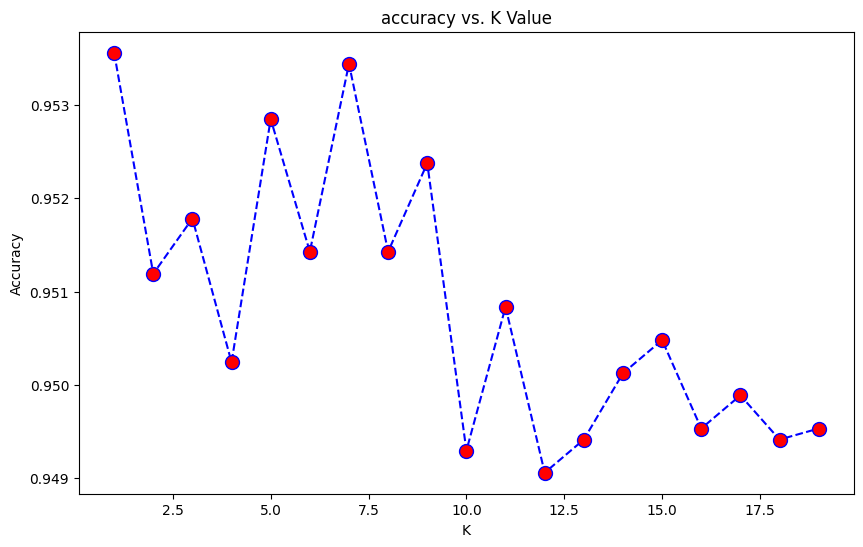

In [60]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

Max accuracy for K = 1 

In [61]:
neigh = KNeighborsClassifier(n_neighbors = 1).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [62]:
confusion_matrix(y_test,y_pred)

array([[5194,  131,   47],
       [ 108,  686,   26],
       [  38,   42, 2169]])

In [63]:
accuracy_score(y_test, y_pred)

0.953560004738775

### 2. KKN using the dataset that excludes the words that do not appear in 5% of the defintions


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X5_df, y, test_size=0.2, random_state=42)

In [65]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9290368439758322 at K = 18


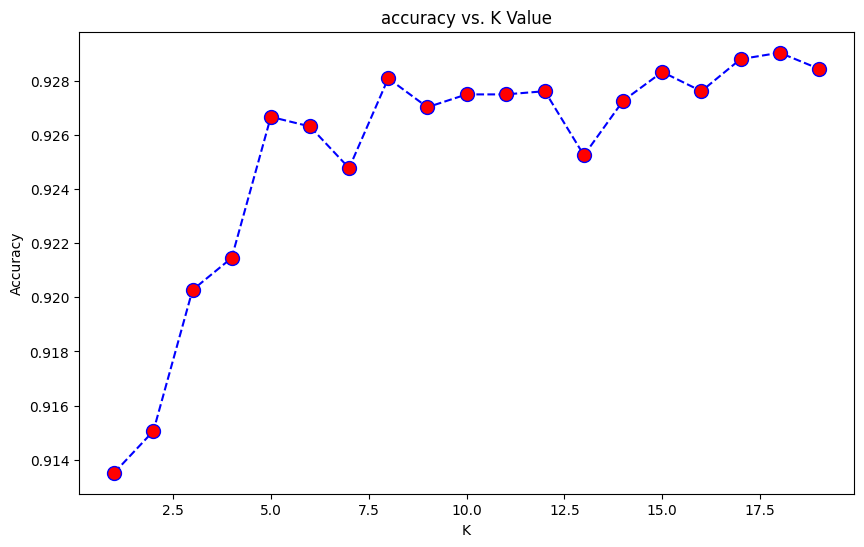

In [66]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

Max accuracy for K = 18

In [67]:
neigh = KNeighborsClassifier(n_neighbors = 18).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [68]:
accuracy_score(y_test, y_pred)

0.9290368439758322

In [69]:
confusion_matrix(y_test,y_pred)

array([[5229,  104,   39],
       [ 258,  540,   22],
       [ 104,   72, 2073]])

### Normalized data

### 1. KKN using the dataset that excludes the words that do not appear in 1% of the defintions


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X1_normalized, y, test_size=0.2, random_state=42)

In [71]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.942305414050468 at K = 1


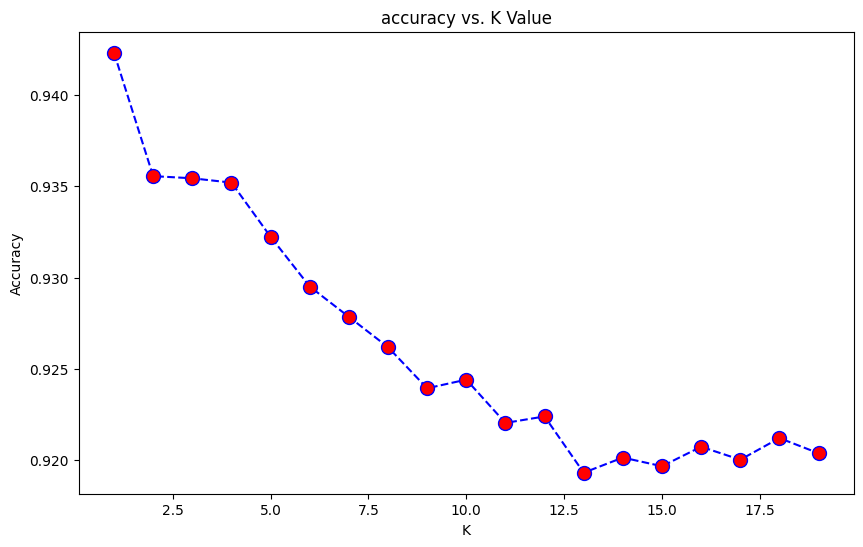

In [72]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)) +1)

Max accuracy for K = 1

In [73]:
neigh = KNeighborsClassifier(n_neighbors = 1).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [74]:
accuracy_score(y_test,y_pred)

0.942305414050468

In [75]:
confusion_matrix(y_test,y_pred)

array([[5158,  142,   72],
       [ 144,  650,   26],
       [  69,   34, 2146]])

### 2. KKN using the dataset that excludes the words that do not appear in 5% of the defintions


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X5_normalized, y, test_size=0.2, random_state=42)

In [77]:
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))

Maximum accuracy: 0.9283260277218339 at K = 11


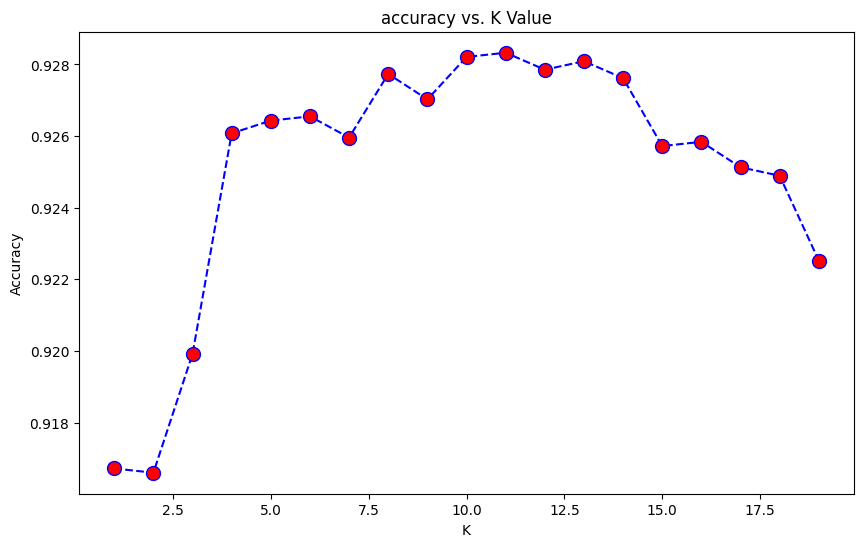

In [78]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

Max accuracy for K = 11

In [79]:
neigh = KNeighborsClassifier(n_neighbors = 11).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [80]:
accuracy_score(y_test,y_pred)

0.9283260277218339

In [85]:
print(confusion_matrix(y_test,y_pred))

[[5208   90   74]
 [ 262  510   48]
 [  83   48 2118]]


In [86]:
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

biological_process       0.94      0.97      0.95      5372
cellular_component       0.79      0.62      0.69       820
molecular_function       0.95      0.94      0.94      2249

          accuracy                           0.93      8441
         macro avg       0.89      0.84      0.86      8441
      weighted avg       0.93      0.93      0.93      8441



### KNN Results
- max accuracy with KNN ignoring words that do not appear in 1% of definitions: 0.953560004738775 (K = 1)
- max accuracy with KNN ignoring words that do not appear in 5% of definitions : 0.9290368439758322 (K = 18)

- max accuracy with KNN on Normalized data ignoring words that do not appear in 1% of definitions: 0.942305414050468 (K = 1)
- max accuracy with KNN on Normalized data ignoring words that do not appear in 5% of definitions: 0.9283260277218339 (K = 11)


### Downsampling (To be used for GridSearch Optimization)

In [26]:
len(df)

42203

In [27]:
df['namespace'].value_counts()

namespace
biological_process    27014
molecular_function    11132
cellular_component     4057
Name: count, dtype: int64

In [28]:
biological_process_df = df[df['namespace'] == 'biological_process']
molecular_function_df = df[df['namespace'] == 'molecular_function']
cellular_component_df = df[df['namespace'] == 'cellular_component']

In [29]:
biological_process_downsampled = resample(biological_process_df, replace = False, n_samples = 1000, random_state=42)
len(biological_process_downsampled)

1000

In [30]:
molecular_function_downsampled = resample(molecular_function_df, replace = False, n_samples = 1000, random_state=42)
len(molecular_function_downsampled)

1000

In [31]:
cellular_component_downsampled = resample(cellular_component_df, replace = False, n_samples = 1000, random_state=42)
len(cellular_component_downsampled)

1000

In [32]:
df_downsampled = pd.concat([biological_process_downsampled,molecular_function_downsampled,cellular_component_downsampled])
len(df_downsampled)

3000

#### Downsampled Labels

In [33]:
y = df_downsampled['namespace']
len(y)

3000

#### a. Dataset that excludes words that do not appear in 1% of definitions

This gives 234 columns

In [34]:
vectorizer1 = CountVectorizer(stop_words='english', min_df=0.01)
X1 = vectorizer1.fit_transform(df_downsampled['definition'])
dense_X1 = X1.toarray()
#creating a df with feature names as columns
X1_df_downsampled = pd.DataFrame(dense_X1, columns=vectorizer1.get_feature_names_out())

In [35]:
X1_df_downsampled.shape

(3000, 238)

#### b. Dataset that excludes words that do not appear in 5% of definitions

This gives 27 columns


In [36]:
vectorizer5 = CountVectorizer(stop_words='english', min_df=0.05)
X5 = vectorizer5.fit_transform(df_downsampled['definition'])
dense_X5 = X5.toarray()
#creating a df with feature names as columns
X5_df_downsampled = pd.DataFrame(dense_X5, columns=vectorizer5.get_feature_names_out())

In [37]:
X5_df_downsampled.shape

(3000, 28)

In [38]:
X5_df_downsampled

,activity,binding,catalysis,cell,cells,chemical,complex,dph,ec,extent,...,pathways,pmid,process,protein,proteins,rate,reaction,reactions,rhea,termgenie
0,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,2,0,0,1,0,0,0,1
4,0,0,0,2,3,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


#### Normalised Downsampled Data

In [39]:
scaler = StandardScaler()

1. Ignoring words that do not appear in 1% of definitions

In [40]:
dense_X1 = X1.toarray()
X1_normalized_downsampled = scaler.fit_transform(dense_X1)
X1_normalized_downsampled = pd.DataFrame(X1_normalized_downsampled, columns=vectorizer1.get_feature_names_out())

In [41]:
X1_normalized_downsampled

,0000058,0198506732,11,13,14,acceptor,acetyl,acid,actin,activates,...,transcription,transfer,transport,transporter,type,udp,um,usually,vesicle,vw
0,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
1,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,6.971423,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
2,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
3,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
4,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
2996,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919
2997,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,7.529828,-0.137919
2998,-0.140408,-0.154566,-0.096929,-0.100703,-0.111468,-0.100882,-0.098208,-0.211908,-0.091337,-0.194173,...,-0.139868,-0.202375,-0.131236,-0.10578,-0.142496,-0.114113,-0.111896,-0.102863,-0.122436,-0.137919


2. Ignoring words that do not appear in 5% of definitions

In [42]:
dense_X5 = X5.toarray()
X5_normalized_downsampled = scaler.fit_transform(dense_X5)
X5_normalized_downsampled = pd.DataFrame(X5_normalized_downsampled, columns=vectorizer5.get_feature_names_out())

In [43]:
X5_normalized_downsampled

,activity,binding,catalysis,cell,cells,chemical,complex,dph,ec,extent,...,pathways,pmid,process,protein,proteins,rate,reaction,reactions,rhea,termgenie
0,3.281971,-0.274089,-0.541417,1.294592,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,-0.645314,1.541374,-0.390041,-0.243323,-0.361656,-0.510785,-0.250398,-0.296883,-0.279237
1,-0.278938,-0.274089,-0.541417,-0.375849,-0.196861,4.017817,-0.40814,-0.245093,-0.366455,-0.355737,...,4.105745,-0.645314,-0.499280,-0.390041,-0.243323,-0.361656,-0.510785,3.993639,-0.296883,-0.279237
2,-0.278938,-0.274089,-0.541417,-0.375849,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,0.478927,1.541374,-0.390041,-0.243323,-0.361656,-0.510785,-0.250398,-0.296883,-0.279237
3,-0.278938,-0.274089,-0.541417,-0.375849,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,2.811063,...,-0.243561,-0.645314,3.582028,-0.390041,-0.243323,2.765056,-0.510785,-0.250398,-0.296883,3.581185
4,-0.278938,-0.274089,-0.541417,2.965033,8.043823,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,0.478927,1.541374,-0.390041,-0.243323,-0.361656,-0.510785,-0.250398,-0.296883,-0.279237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.278938,-0.274089,-0.541417,1.294592,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,-0.645314,-0.499280,-0.390041,-0.243323,-0.361656,-0.510785,-0.250398,-0.296883,-0.279237
2996,-0.278938,-0.274089,-0.541417,-0.375849,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,-0.645314,-0.499280,-0.390041,-0.243323,-0.361656,-0.510785,-0.250398,-0.296883,-0.279237
2997,-0.278938,-0.274089,-0.541417,-0.375849,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,0.478927,-0.499280,-0.390041,-0.243323,-0.361656,-0.510785,-0.250398,-0.296883,3.581185
2998,-0.278938,-0.274089,-0.541417,-0.375849,-0.196861,-0.248891,-0.40814,-0.245093,-0.366455,-0.355737,...,-0.243561,0.478927,-0.499280,-0.390041,2.958299,-0.361656,-0.510785,-0.250398,-0.296883,-0.279237


### Support Vector Machines

### Non-Normalised Dataset

#### 1. Ignoring the words that do not appear in 1% of definitions

##### Optimizing using downsampled data


In [53]:
y = df_downsampled['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_df_downsampled, y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [77]:
accuracy_score(y_test, y_pred)
#0.9702641867077361

0.9579166666666666

In [39]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
#runnning

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [40]:
grid_search.best_estimator_

SVC(C=10)

In [41]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


#### Testing on full dataset 

In [54]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_df, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=10)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [55]:
confusion_matrix(y_test, y_pred)

array([[5299,   60,   13],
       [  95,  710,   15],
       [  26,   20, 2203]])

In [56]:
accuracy_score(y_test, y_pred)

0.9728705129723967

In [57]:
y_test.value_counts()

namespace
biological_process    5372
molecular_function    2249
cellular_component     820
Name: count, dtype: int64

#### Use PCA to plot graph

In [29]:
pca = PCA()
X_pca = pca.fit_transform(X1_df)

In [30]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = [str(x) for x in range(1, len(per_var) + 1)]

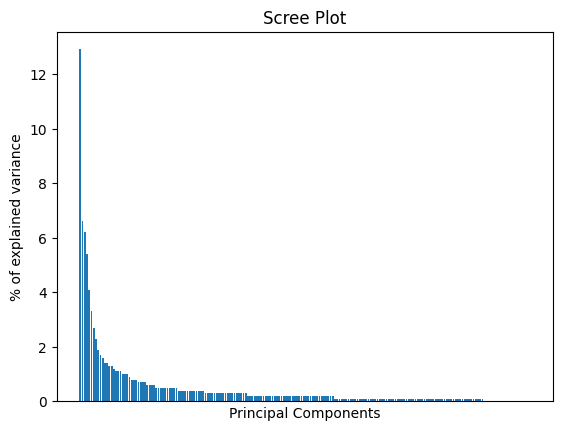

In [31]:
plt.bar(x=range(1,len(per_var) + 1), height = per_var)
plt.tick_params(
    axis = 'x',
    which = 'both',
    bottom = False,
    top = False,
    labelbottom = False)
plt.ylabel('% of explained variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [36]:
train_pc1_coords = X_pca[:,0]
train_pc2_coords = X_pca[:,1]

In [43]:
pca_train_scaled = scaler.fit_transform(np.column_stack((train_pc1_coords,train_pc2_coords)))

In [45]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 0.0001, 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose = 2)
grid_search.fit(pca_train_scaled, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  11.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  11.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  12.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  12.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  12.9s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   7.8s
[CV] END ....................C=0.1, gamma=scal

In [61]:
clf_svm = SVC(C=10)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [62]:
accuracy_score(y_test, y_pred)

0.7970619594834735

##### Accuracy score using SVM and ignoring words that do not appear in 1% of  definitions: 0.9728705129723967

#### 2. Ignoring the words that do not appear in 5% of definitions

In [100]:
y = df_downsampled['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_df_downsampled, y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [101]:
accuracy_score(y_test, y_pred)

0.8970833333333333

In [102]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [103]:
grid_search.best_estimator_

SVC(C=10, gamma=0.1)

In [104]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


#### Testing on full dataset 

In [105]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_df, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=10, gamma = 0.1)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [106]:
confusion_matrix(y_test, y_pred)

array([[5270,   69,   33],
       [ 281,  517,   22],
       [  77,   68, 2104]])

In [107]:
accuracy_score(y_test, y_pred)

0.9348418433834854

### Normalised Dataset

#### 1. Ignoring the words that do not appear in 1% of definitions

In [114]:
y = df_downsampled['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_normalized_downsampled, y, test_size=0.2, random_state=42)

In [117]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [118]:
accuracy_score(y_test, y_pred)

0.9491666666666667

In [119]:
confusion_matrix(y_test, y_pred)

array([[750,  69,   9],
       [ 14, 767,   2],
       [  6,  22, 761]])

In [120]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [121]:
grid_search.best_estimator_

SVC(C=10, gamma=0.001)

In [122]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [123]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X1_normalized, y, test_size=0.2, random_state=42)
clf_svm = SVC(C=10, gamma = 0.1)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [124]:
confusion_matrix(y_test, y_pred)

array([[5337,   30,    5],
       [ 533,  286,    1],
       [ 695,    1, 1553]])

In [125]:
accuracy_score(y_test, y_pred)

0.8501362397820164

#### 2. Ignoring the words that do not appear in 5% of definitions

In [44]:
y = df_downsampled['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_normalized_downsampled, y, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [45]:
accuracy_score(y_test, y_pred)

0.8916666666666667

In [46]:
confusion_matrix(y_test, y_pred)

array([[171,  45,   1],
       [  3, 178,   5],
       [  1,  10, 186]])

In [47]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
##Downsample changed to 1000 per namespace

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [50]:
grid_search.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [69]:
y = df['namespace']
X_train, X_test, y_train, y_test = train_test_split(X5_normalized, y, test_size=0.2, random_state=42)
clf_svm = SVC(C =10)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

In [70]:
confusion_matrix(y_test, y_pred)

array([[5266,   66,   40],
       [ 286,  511,   23],
       [  77,   61, 2111]])

In [71]:
accuracy_score(y_test, y_pred)

0.9344864352564862

### Random Forests

#### Non Normalised Dataset

### ignoring words not appearing in 1% defs


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X1_df, y, test_size=0.2, random_state=42)

In [86]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy')

In [88]:
 random_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': False}

In [87]:
best_rf = random_search.best_estimator_
# Train the best model on the entire training set
best_rf.fit(X_train, y_train)
# Predict on the test set
y_pred = best_rf.predict(X_test)


In [89]:
accuracy_score(y_test, y_pred)

0.9748844923587253

In [118]:
rf = RandomForestClassifier(n_estimators = 300)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [119]:
accuracy_score(y_test, y_pred)

0.9761876554910556

#### Normalised Dataset

In [42]:
#ignoring words not appearing in 5% defs
vectorizer = CountVectorizer(stop_words='english', min_df=0.05)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
y = df['namespace']
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [46]:
rf = RandomForestClassifier()

In [47]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.9360265371401493

In [49]:
#ignoring words not appearing in 1% defs
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
X = vectorizer.fit_transform(df['definition'])
dense_X = X.toarray()
y = df['namespace']
scaler = StandardScaler()
X_normalized = scaler.fit_transform(dense_X)
X_normalized = pd.DataFrame(X_normalized, columns=vectorizer.get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [50]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9748844923587253

### Normalised Dataset

### Method

1. Breakdown input text into feature set
2. Run KNN on definitions using feature set

##### Function to get feature set from an input text




In [76]:
"""
    Takes a paragraph 
"""
def get_feature_set_from_text(input_text: str)->List[str]:
    return []
